<span style="color:#ff8c00; font-size:28px; font-weight:700;">Introduction — Benchmark retrieval RAG : une config unique, multi-params, rejouable et auditable</span>

### Définir le “Positif” d’abord : notre boussole *risk-first*
Dans ce notebook, notre démarche part d’un choix explicite : **la définition opérationnelle de “Positif”**, car elle fixe immédiatement ce que signifient **TP/FN** et donc **quelles métriques sont légitimes**.

✅ **Définition de “Positif” retenue ici (P1)** :  
**`passage_hit_k` (query-level)** — *Positif ⇔ au moins 1 passage (chunk) jugé pertinent apparaît dans le top-k.*  
🎯 Conséquence : la priorité produit est **risk-first** → **réduire les FN retrieval** (aucune bonne source dans le top-k), puis seulement ensuite optimiser l’ordre.

🧠 Contexte entretien (Mehdi & Julien)  
Lors de notre échange, plusieurs lectures possibles des FN ont été abordées (FN “aucune bonne source”, FN “pas le bon document canonique”, FN “preuves insuffisantes”, FN “réponse finale impossible → no-answer”).  
➡️ Notre conclusion méthodologique : **on choisit une définition de P (ici P1), puis on aligne strictement les métriques et l’audit sur ce choix**, avant d’ouvrir d’autres définitions (P2/P3/P4) dans d’autres notebooks.

---

## Démarche expérimentale réalisée (multi-params + reproducibilité + audit total)
Ce repo met en place un **banc d’essai de retrieval** : l’objectif n’est pas “faire tourner un RAG complet”, mais **mesurer et comparer** des décisions de retrieval de manière contrôlée.
🔁 **Contrat stable d’exécution** (rejouable) :  
**Config (YAML) → Run (exécution) → Artefacts (logs, résultats, métriques, configs archivées)**. 

🧾 **Audit & traçabilité** (ce qui rend une comparaison crédible) :  
- `config_used.yaml` + `config_resolved.yaml` (intention vs réalité exécutée) 
- `run.log` + `timings.json` (comprendre “pourquoi” et “combien ça coûte”)
- `results.jsonl` + `metrics.json` (ce qui est effectivement remonté + mesure IR)

🧩 **Multi-params sélectionnables dans un YAML unique** (comparaisons propres) :
- **Chunking** (hyperparamètre à benchmarker, pas à “choisir au feeling”)  
- **Filtrages métier + temporalité** (décision produit mesurable, pas juste optimisation perf) 
- **Mode (stratégie)** : BM25 / Dense / Hybrid (RRF)
- **Retriever (backend)** : mémoire / Elasticsearch / (Qdrant à venir)  

📌 Point clé de design : **`mode` (signal) ≠ `retriever` (moteur d’exécution)**, ce qui permet de garder une stratégie stable tout en changeant de backend. 


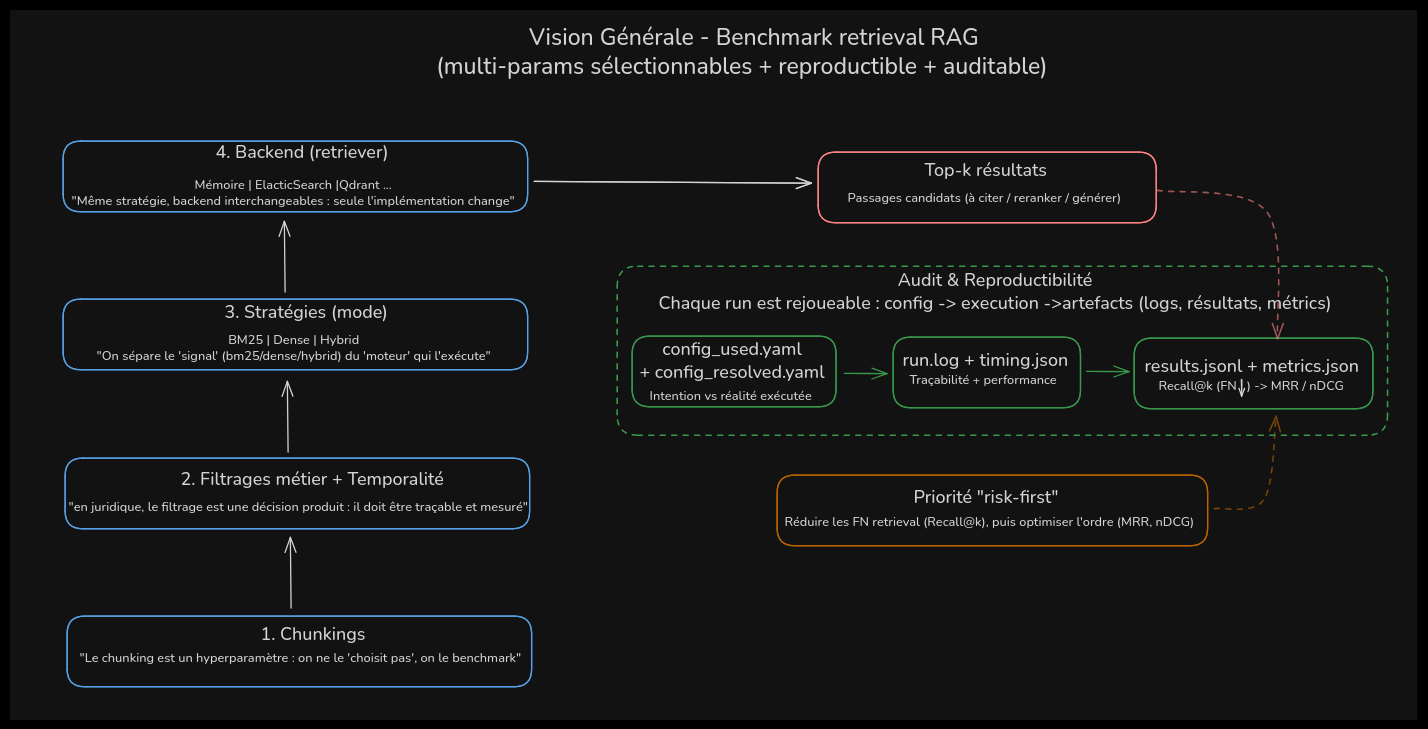

## <span style="color:#ff8c00; font-size:26px; font-weight:700;">Résumé cette vision “Benchmark retrieval RAG” (rejouable + auditable)</span>


> ⚠️ Note : la partie “Interprétation humaine des métriques via FN/FP (et variantes)” est volontairement exclue ici car déjà traitée dans l’autre notebook.

---

### 🎯 0) Objectif du repo : bench de retrieval (pas encore “RAG complet”)
Ce repo met en place un **banc d’essai de retrieval** pour un futur RAG juridique : rendre chaque décision (chunking, filtres, mode, backend, fusion) **mesurable**, **audit-able** et **reproductible**, avant toute industrialisation.

---

### 🧱 1) Données : documents, chunks, corpus chunké
- **Document** : unité source (article, jugement, section…).
- **Chunk** : passage issu du découpage (chunking) + métadonnées. 
- Le **chunking** est une étape amont et un **paramètre d’expérience** (plusieurs corpus chunkés possibles).

🔑 Identifiants & portabilité :  
- `doc_key` = identifiant stable recommandé.
- Certains champs sources contiennent des chemins Windows (`D:\...`) : à traiter comme **métadonnées d’audit**, pas comme chemins exploitables (portabilité Linux/WSL).

---

### 🏗️ 2) Architecture : contrat “Config → Run → Artefacts”
`run.py` orchestre : charge données, applique filtres, exécute le retriever, calcule métriques, écrit les artefacts. 

🧾 Artefacts typiques (audit) :  
- `config_used.yaml` / `config_resolved.yaml` (intention vs réalité exécutée) 
- `*_results.jsonl` (top-k par requête) + `metrics_*.json` (Recall/Hit@k, MRR, nDCG@k)
- `run.log`, `timings.json`, `result.json` (trace + performance).

---

### 🔎 3) Filtrages métier + temporalité (juridique)
Avant retrieval, on réduit le corpus à un sous-univers pertinent.

- **Filtrage métier** : `doc_type`, titres, code ciblé, règles d’inclusion/exclusion…  
  ✅ En juridique, c’est une **décision produit** : elle impacte la couverture (recall) et doit être tracée/mesurée. 

- **Filtrage temporel** : date `as_of` + mode `strict_temporal` (gérer l’absence de métadonnées de date).  

---

### 🧠 4) Stratégies (modes) : BM25 / Dense / Hybrid (RRF)
- **BM25 (lexical)** : très fort quand les requêtes sont “article-centric” (termes précis, numéros, etc.).
- **Dense (vectoriel)** : embeddings + similarité (cosine), robuste aux reformulations/synonymes.
- **Hybrid** : combine BM25 + dense via **RRF** (shortlists + fusion), avec paramètres clés (`bm25_shortlist`, `rrf_k`).  

📌 Nuance : hybrid peut améliorer le recall global mais peut aussi ajouter du bruit sur certains cas → d’où l’intérêt des métriques + audit qualitatif.

---

### ⚙️ 5) Backends (retrievers) : mémoire / Elasticsearch (réalisés) / Qdrant (à venir)
- **Mémoire (Python)** : rapide à itérer, contrôlable pour bench ; moins scalable.  
- **Elasticsearch (serveur)** : BM25 natif, dense via `dense_vector` + kNN, hybrid possible “outside ES” (fusion côté Python) ou “inside ES” (scoring combiné). 
- **Qdrant (à venir)** : surtout vectoriel ; hybrid souvent multi-backends (BM25 via ES/OpenSearch + dense via Qdrant + fusion appli).ndex=28}  

✅ Conclusion architecture :  
- **`mode` = stratégie (signal bm25/dense/hybrid)**  
- **`retriever` = moteur (mémoire/ES/Qdrant/ANN…)**

---

### 🧩 6) Design YAML : `retriever` vs `mode`
Avant, `retriever: bm25|dense|hybrid` mélangeait backend et stratégie.  
Maintenant : `retriever` (backend) + `mode` (stratégie) → architecture plus propre, extensible, comparable. 

---

### 📏 7) Évaluation IR : qrels + métriques (au niveau retrieval)
L’évaluation repose sur des **qrels** (vérité terrain) : comparaison des top-k retournés vs documents attendus. 

Métriques principales :  
- **Recall/Hit@k** : couverture (éviter de rater une bonne source)
- **MRR** : rang du premier pertinent (accès rapide à la bonne source) 
- **nDCG@k** : qualité globale de l’ordre (expérience “liste de résultats”).

---

### 🧪 8) Exécution & infra : séparation claire des rôles
- Docker/compose = **infra** (ex : démarrer Elasticsearch).  
- `run.py` + YAML = **orchestration des runs** (itérations, comparaisons, métriques, audit).  

---

### 🗺️ 9) Roadmap “production-grade” (logique)
Axes identifiés :  
1) étude systématique du corpus + temporalité (versions, dates, structures XML)
2) query understanding (dictionnaire, expansions contrôlées)
3) scalabilité retrieval (ANN/FAISS/HNSW ou vector DB) + reranking si besoin  
4) réponse juriste : citations obligatoires + stratégie no-answer  
5) observabilité : logs structurés, métriques runtime, CI/tests. 

---

### ✅ Conclusion : pourquoi ce notebook est “benchmark-first”
Notre approche vise à éviter les faux progrès :  
- **une config unique** pour piloter des variantes comparables,  
- **des artefacts d’audit** pour expliquer et rejouer,  
- **des métriques IR** pour mesurer,  
- puis seulement ensuite l’extension vers temporalité, no-answer, citations fines et pipeline end-to-end.

---
---

## <span style="color:green; font-weight:700;">Extrait d'un “run” Hybrid → Elasticsearch</span>
### <span style="color:#ffd400; font-weight:700;">Sur les Query suivantes</span>

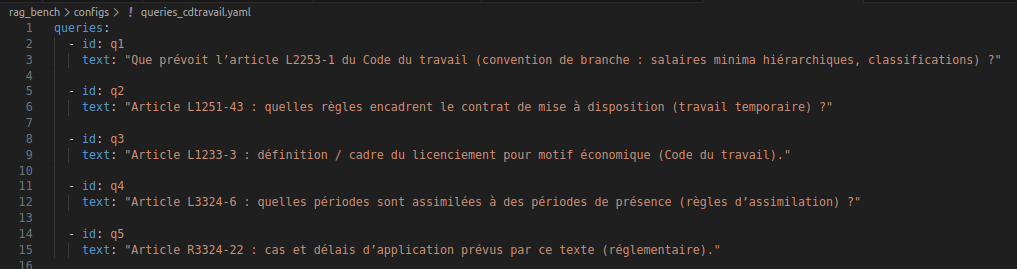

### <span style="color:#ffd400; font-weight:700;">et Table de vérité (incomplète) de référence</span>

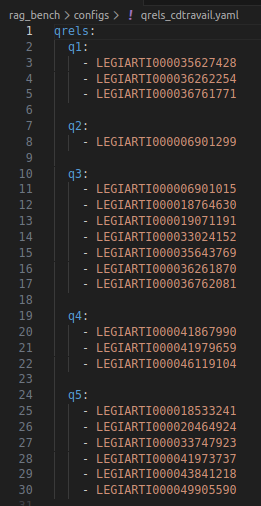

### <span style="color:#ffd400; font-weight:700;">Vue du dossier unique du run</span>

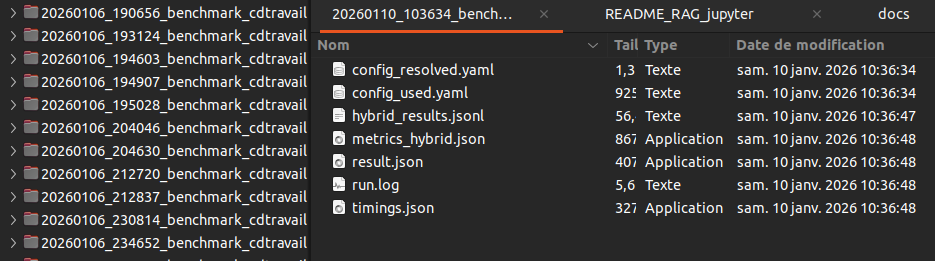

### <span style="color:#ffd400; font-weight:700;">Vue du YAML de lancement résolu : config_resolved.yaml</span>

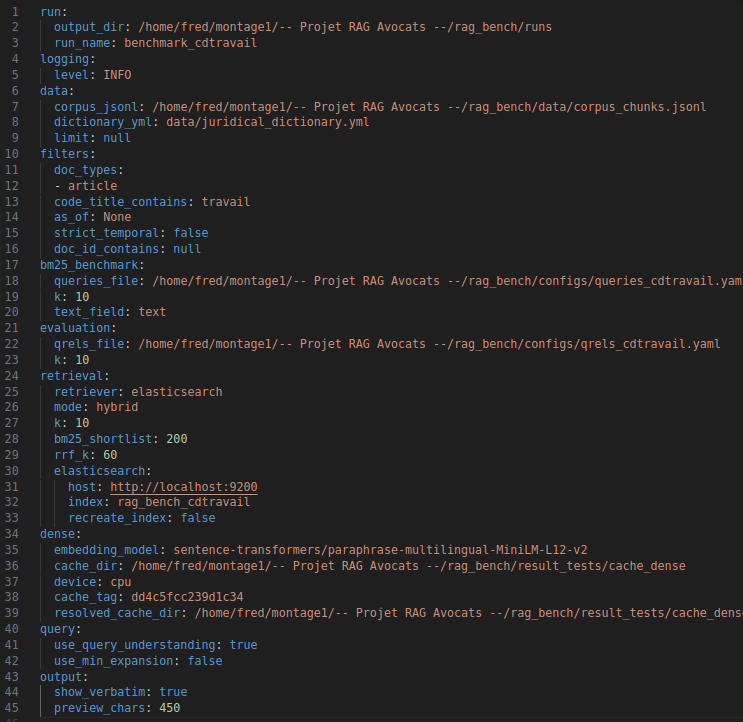

### <span style="color:#ffd400; font-weight:700;">Vue des résultats : metrics_hybrid.json</span>

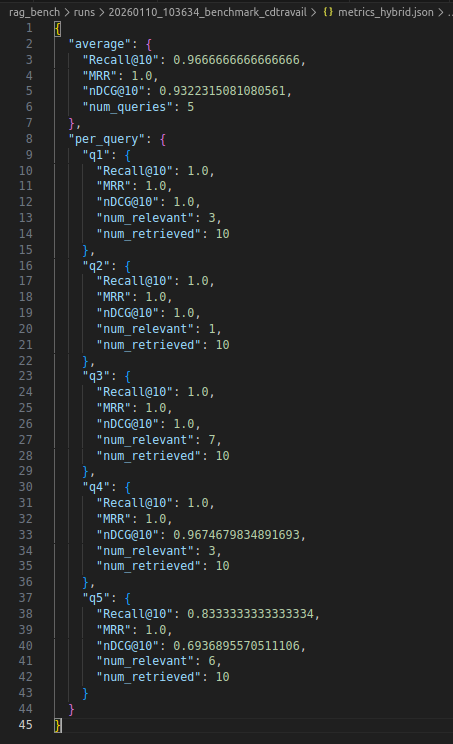

### <span style="color:#ffd400; font-weight:700;">Vue du timing du run</span>

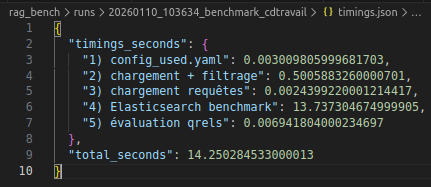

### <span style="color:#ffd400; font-weight:700;">Voir les autres production dans notre repo GitHub</span>
- config_used.yaml
- hybrid_results.jsonl
- result.json
- run.log